In [6]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.manager import SwarmManager
from backtester.exoinfo import EXOInfo

import pandas as pd
import numpy as np
import scipy

In [7]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
swarms = {}
for file in os.listdir('./swarms/'):
    swarm_name = file.replace('.swm','')
    swarms[swarm_name] = SwarmManager.load(os.path.join('swarms', file))

In [4]:
swarms

{'ZLE_BearishCollar_MACross_Long': <backtester.swarms.manager.SwarmManager at 0x7f4c0e165dd8>,
 'ZLE_BearishCollar_MACross_Short': <backtester.swarms.manager.SwarmManager at 0x7f4c0e183b38>,
 'ZLE_BearishCollar_SwingPoint_Short': <backtester.swarms.manager.SwarmManager at 0x7f4c0e207438>,
 'ZLE_BearishPut_MACross_Long': <backtester.swarms.manager.SwarmManager at 0x7f4c0e1dbef0>,
 'ZLE_BearishPut_MACross_Short': <backtester.swarms.manager.SwarmManager at 0x7f4c0e1db898>,
 'ZLE_BullishCall_MACross_Long': <backtester.swarms.manager.SwarmManager at 0x7f4c0e1db7f0>,
 'ZLE_BullishCall_MACross_Short': <backtester.swarms.manager.SwarmManager at 0x7f4c0e1dbeb8>,
 'ZLE_BullishCollar_MACross_Long': <backtester.swarms.manager.SwarmManager at 0x7f4c0e1db5f8>,
 'ZLE_BullishCollar_MACross_Short': <backtester.swarms.manager.SwarmManager at 0x7f4c0e1a8b38>}

In [11]:
mat_file = './exo/strategy_2010348.mat'
exo = EXOInfo.from_matfile(mat_file)

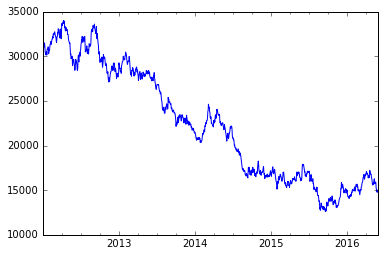

In [13]:
exo.data.fut_price.plot()

In [61]:

campaign_exposure = {
     'ZLE_BearishCollar_MACross_Long': 1,
     'ZLE_BearishCollar_MACross_Short': 1,
     'ZLE_BearishCollar_SwingPoint_Short': 1,
     'ZLE_BearishPut_MACross_Long': 1,
     'ZLE_BearishPut_MACross_Short': 1,
     'ZLE_BullishCall_MACross_Long': 1,
     'ZLE_BullishCall_MACross_Short': 1,
     'ZLE_BullishCollar_MACross_Long': 1,
     'ZLE_BullishCollar_MACross_Short': 1,
}

In [62]:
#def campaign_equity(swarms, exposure):
exposure = campaign_exposure

campaign_dict = {}
for swarm_name, smgr in swarms.items():
    campaign_dict[swarm_name] = smgr.swarm_picked.diff().sum(axis=1) * exposure[swarm_name]
    
campaign_portfolio = pd.DataFrame(campaign_dict).cumsum()
campaign_equity = campaign_portfolio.sum(axis=1)

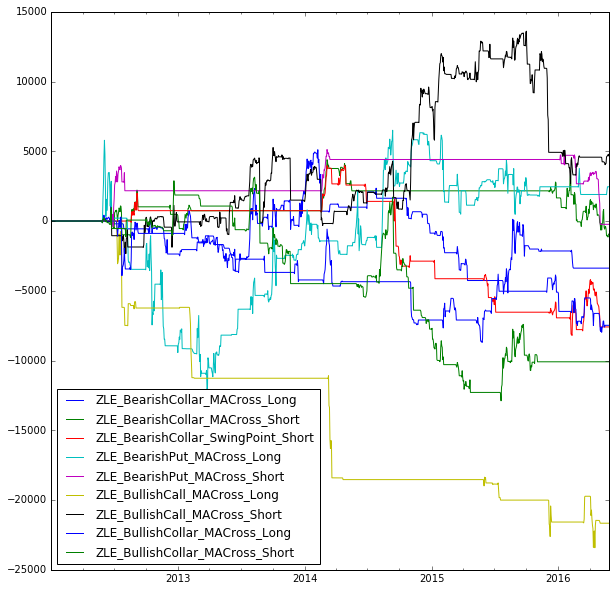

In [63]:
figsize(10,10)
campaign_portfolio.plot()

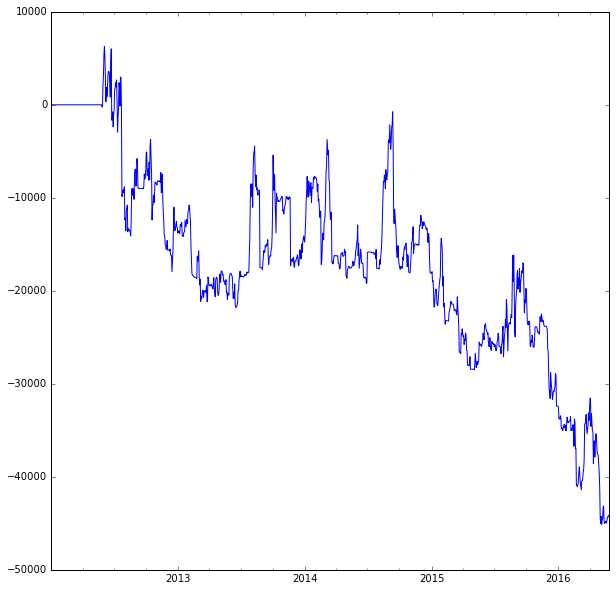

In [64]:
campaign_portfolio.sum(axis=1).plot()

In [65]:
## Campaign results

In [70]:
size_futures_long = 80
size_futures_short = 80
size_campaign = 40

In [71]:
futures_index = exo.data.fut_price.diff().cumsum()

## long/short futures

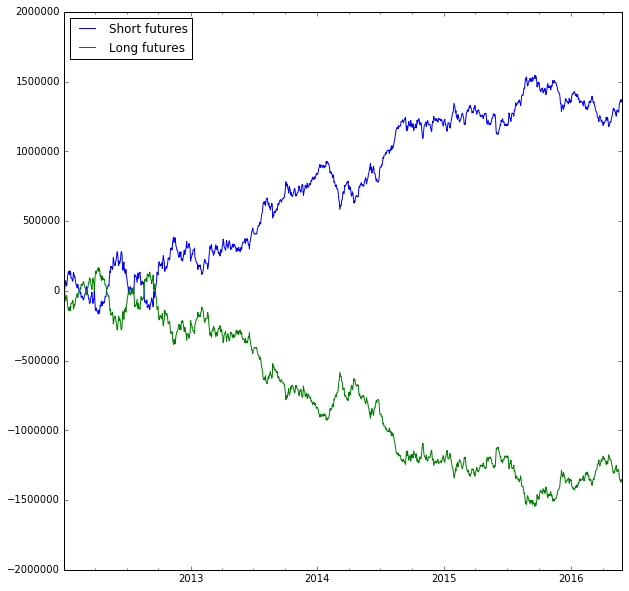

In [72]:
(futures_index*-1*size_futures_short).plot(label='Short futures')
(futures_index*size_futures_long).plot(label='Long futures')

legend(loc=2)

## Futures and bidirectional campaign

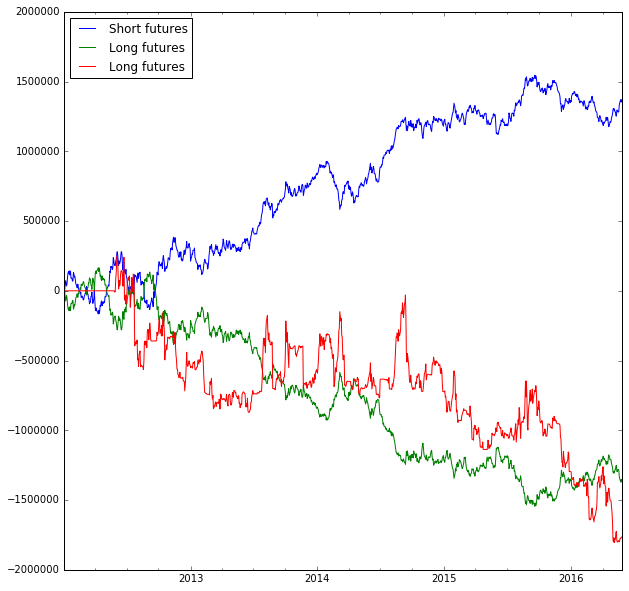

In [73]:
(futures_index*-1*size_futures_short).plot(label='Short futures')
(futures_index*size_futures_long).plot(label='Long futures')
(campaign_equity*size_campaign).plot(label='Long futures')

legend(loc=2)